In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.model_selection import GridSearchCV
import pickle as pkl
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [2]:
#Read in the data
heart_df=pd.read_csv('Data/heart.csv')

Let's start by making some initial models

In [3]:
#Split up the data
X=heart_df.drop('target',axis=1)
y=heart_df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [4]:
#Create the Logistic Regression Model
#Instantiate
lg=LogisticRegression()
#Fit the model
lg_fit=lg.fit(X_train,y_train)
#Make predictions
lg_preds=lg.predict(X_test)
#Assess accuracy
accuracy_score(lg_preds,y_test)
#Cross validate scores
scores=cross_val_score(lg,X,y,cv=10)
print(scores)

[0.86407767 0.90291262 0.85436893 0.82524272 0.84466019 0.90196078
 0.79411765 0.82352941 0.7745098  0.80392157]


In [5]:
#Create the Logistic SVM Model
#Instantiate
sv=SVC()
#Fit the model
sv_fit=sv.fit(X_train,y_train)
#Make predictions
sv_preds=sv_fit.predict(X_test)
#Assess accuracy
accuracy_score(sv_preds,y_test)
#Cross validate scores
scores=cross_val_score(sv,X,y,cv=10)
print(scores)

[0.65048544 0.69902913 0.77669903 0.67961165 0.69902913 0.73529412
 0.64705882 0.64705882 0.70588235 0.65686275]


In [6]:
#Instantiate
dt=DecisionTreeClassifier()
#Fit the model
dt_fit=dt.fit(X_train,y_train)
#Make predictions
dt_preds=dt_fit.predict(X_test)
#Assess accuracy
accuracy_score(dt_preds,y_test)
#Cross validate scores
scores=cross_val_score(dt,X,y,cv=10)
print(scores)

[1.         1.         1.         0.97087379 1.         1.
 1.         1.         1.         1.        ]


In [7]:
#Instantiate
rf=RandomForestClassifier()
#Fit the model
rf_fit=rf.fit(X_train,y_train)
#Make predictions
rf_preds=rf.predict(X_test)
#Assess accuracy
accuracy_score(rf_preds,y_test)
#Cross validate scores
scores=cross_val_score(rf,X,y,cv=10)
print(scores)

[1.         1.         1.         1.         1.         1.
 1.         1.         0.97058824 1.        ]


In [8]:
#Instantiate
xg=xgb.XGBClassifier()
#Fit the model
dt_xg=xg.fit(X_train,y_train)
#Make predictions
xg_preds=xg.predict(X_test)
#Assess accuracy
accuracy_score(xg_preds,y_test)
#Cross validate scores
scores=cross_val_score(xg,X,y,cv=10)
print(scores)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Let's try to eliminate some overfitting

In [9]:
#Create overall testing and training set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
#Create sub testing and training set to test models
sub_X_train,sub_X_test,sub_y_train,sub_y_test = train_test_split(X_train,y_train,test_size=0.2)

In [10]:
#Since XGboost was the best, we will repeat it for these other concepts
xg=xgb.XGBClassifier()
xg_fit=xg.fit(sub_X_train,sub_y_train)
xg_preds=xg.predict(sub_X_test)
accuracy_score(xg_preds,sub_y_test)
scores=cross_val_score(xg,X_train,y_train,cv=10)
print(scores)

[0.98780488 0.97560976 0.98780488 1.         0.97560976 1.
 1.         1.         1.         0.95121951]


In [11]:
#Assess accuracy on the overall model
xg_preds_overall=xg_fit.predict(X_test)
accuracy_score(xg_preds_overall,y_test)

0.975609756097561

Let's show off some other accuracy metrics

In [12]:
#Let's see what the f1_score is 
f1_score(xg_preds_overall,y_test)

0.9758454106280192

In [13]:
#Let's check roc
roc_curve(xg_preds_overall,y_test)

(array([0.        , 0.01980198, 1.        ]),
 array([0.        , 0.97115385, 1.        ]),
 array([2, 1, 0], dtype=int64))

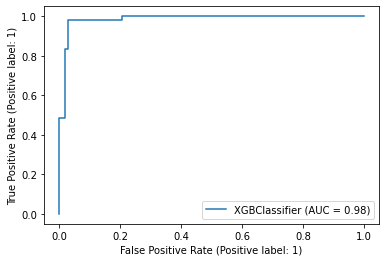

In [14]:
#ROC curve is excellent
plot_roc_curve(xg_fit,X_test,y_test)

In [15]:
#Confusion Matrix
cm=confusion_matrix(xg_preds_overall,y_test)
cm

array([[ 99,   2],
       [  3, 101]], dtype=int64)

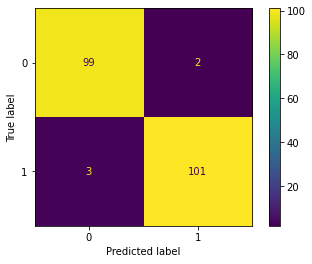

In [16]:
#not so informative, let's try this
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xg.classes_)
disp.plot()

Now let's do some parameter optimization

In [17]:
#Optimize parameters
#Create param grid
param_grid={'learning_rate': [0.01,0.05,0.1],
           'n_estimators': [10,100,1000],
           'max_depth': [3,6,10]}
#Instantiate grid search
gs_cv=GridSearchCV(estimator=xg,param_grid=param_grid)
#Find the grid search model
gs_model=gs_cv.fit(X_train,y_train)
#cross validate the grid searched model
cross_val_score(gs_model,X_train,y_train,cv=10)

array([0.98780488, 0.97560976, 0.96341463, 1.        , 0.97560976,
       1.        , 1.        , 1.        , 1.        , 0.97560976])

In [18]:
#Test model on the external testing set to ensure a lack of over fitting
gs_preds=gs_model.predict(X_test)
accuracy_score(gs_preds,y_test)

1.0

Now let's save and load the optimized model

In [19]:
#save the model to a pickle file
#open file
f=open('Models/model.pkl','wb')
#dump model into pickle file
pkl.dump(gs_model,f)
#close file
f.close()

In [20]:
#load a model from a pcikle file
#open file
f=open('Models/model.pkl','rb')
#read in model
model=pkl.load(f)
#close file
f.close()

Let's see what happens when we standardize the data

In [21]:
#Let's try a standardization method
#instantiate
ss=StandardScaler()
#fit and transform the data
data=ss.fit_transform(X)
print(data)

[[-0.26843658  0.66150409 -0.91575542 ...  0.99543334  1.20922066
   1.08985168]
 [-0.15815703  0.66150409 -0.91575542 ... -2.24367514 -0.73197147
   1.08985168]
 [ 1.71659547  0.66150409 -0.91575542 ... -2.24367514 -0.73197147
   1.08985168]
 ...
 [-0.81983438  0.66150409 -0.91575542 ... -0.6241209   0.23862459
  -0.52212231]
 [-0.4889957  -1.51170646 -0.91575542 ...  0.99543334 -0.73197147
  -0.52212231]
 [-0.04787747  0.66150409 -0.91575542 ... -0.6241209   0.23862459
   1.08985168]]


In [22]:
#turn standardized data into a frame
standardized_df_x=pd.DataFrame(data)
standardized_df_x.columns=X.columns

In [23]:
#split and subsplit the data
X_train,X_test,y_train,y_test = train_test_split(standardized_df_x,y,test_size=0.2)

sub_X_train,sub_X_test,sub_y_train,sub_y_test = train_test_split(X_train,y_train,test_size=0.2)

In [24]:
#load data into an XGBoost model
xg=xgb.XGBClassifier()
xg_fit=xg.fit(sub_X_train,sub_y_train)
xg_preds=xg.predict(sub_X_test)
accuracy_score(xg_preds,sub_y_test)
scores=cross_val_score(xg,X_train,y_train,cv=10)
print(scores)

[1.         1.         0.98780488 1.         1.         0.97560976
 0.98780488 1.         1.         1.        ]


In [25]:
#Ensure lack of overfitting 
xg_preds_overall=xg_fit.predict(X_test)
accuracy_score(xg_preds_overall,y_test)

1.0

Now let's try some feature elimination

In [26]:
#Now let's try some dimensionality reduction
#instantiate PCA
pca=PCA()
#Fit and transform 
pc_data=pca.fit_transform(standardized_df_x)
print(pc_data)

[[-0.52255555 -1.11280319  0.95681551 ... -0.55883786 -0.35637623
  -0.11790814]
 [ 2.59038087 -0.53316168  1.46731492 ... -0.65429855 -0.85577252
   0.28130316]
 [ 3.04235195 -1.32752064 -0.42476481 ... -0.51925043 -0.89645601
   0.9471883 ]
 ...
 [ 1.24507316 -1.45735643 -0.4738734  ...  0.41915953  0.76503283
   0.07844114]
 [-1.62005298  0.12444348 -1.32795605 ... -0.31917042 -0.18881188
  -0.38606238]
 [ 0.93416859 -1.77854872 -0.00588162 ... -0.98859473  0.7812546
  -0.24090225]]


In [27]:
#Put results into a dataframe
pc_data_df=pd.DataFrame(pc_data)
pc_data_df.columns=['comp'+str(i) for i in range(len(X.columns))]
#Let's see the explained ratio per feature
print(pca.explained_variance_ratio_)

[0.21369912 0.11971959 0.09238384 0.08994039 0.07685925 0.07479569
 0.06741785 0.05907578 0.05584142 0.04849683 0.04017354 0.0332042
 0.02839249]


<AxesSubplot:xlabel='comp1', ylabel='comp2'>

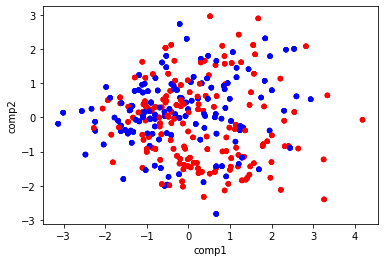

In [28]:
#Let's see a 2d representation of our data
plot_df=pc_data_df[['comp1','comp2']]
color_dict={0:'blue',1:'red'}
plot_df['color']=[color_dict[i] for i in y]
plot_df.plot('comp1','comp2',kind='scatter',color=plot_df['color'])

In [29]:
#Let's see what happens when we only want to see features that consist of 90% of the variance
pc_data_df.drop(['comp10','comp11','comp12'],axis=1,inplace=True)

In [30]:
#Split and subsplit the data
X_train,X_test,y_train,y_test = train_test_split(pc_data_df,y,test_size=0.2)

sub_X_train,sub_X_test,sub_y_train,sub_y_test = train_test_split(X_train,y_train,test_size=0.2)

In [31]:
#Create, fit, and evaluate the model
xg=xgb.XGBClassifier()
xg_fit=xg.fit(sub_X_train,sub_y_train)
xg_preds=xg.predict(sub_X_test)
accuracy_score(xg_preds,sub_y_test)
scores=cross_val_score(xg,X_train,y_train,cv=10)
print(scores)

[1.         0.98780488 1.         0.98780488 1.         0.96341463
 1.         1.         1.         1.        ]


In [32]:
#Ensure lack of overfitting 
xg_preds_overall=xg_fit.predict(X_test)
accuracy_score(xg_preds_overall,y_test)

0.9951219512195122